# ak-energy-data Data Updating Administrative Tasks

This notebook is used to update and maintain the data on the ak-energy-data.analysisnorth.com site.  The data on that site is arranged in a hierarchical directory structure; top-level directories indicate the general type of data, e.g. `wx` (weather) and `city-util` (city and utility).  Sub-directories may be present to further categorize data.  Generally at the bottom level of the directory structure are two folders: `raw` and `proc`.  The `raw` folder holds the unprocessed source data, like an unprocessed TMY3 file.  The `proc` folder holds data that has been processed and transformed from the `raw` folder.

That directory structure is mirrored in the `data` directory of this GitHub repo.  This notebook operates on that local data. The general approach to updating the data is to update the raw source data in your local GitHub repo and then run the relevant sections of code below to produce the processed data.  Once you are satisfied with the results, the final code in each section below allows you to upload the new data to the live site.


**NOTE:** The live site is stored on an Amazon Web Services (AWS) S3 bucket configured for static web site hosting. Updating that data requires AWS permissions that allow updating
the `ak-energy-data.analysisnorth.com` S3 bucket.  It also requires that the `boto3` Python is installed, which allows for manipulation of AWS S3 data.

In [5]:
# Execute this cell prior to any of the cells below
import os
from glob import glob
from datetime import datetime
import importlib
import csv
import io
import math
import pandas as pd
import numpy as np
import admin_util as au  # a utility library in this repo.
#importlib.reload(au)    # needed if you modify the admin_util library

from matplotlib.pyplot import *
# Show Plots in the Notebook
%matplotlib inline

bucket = au.Bucket('ak-energy-data.analysisnorth.com')

In [6]:
rcParams['figure.figsize']= (9, 5)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

## Upload Index Notebook to the Site

Do this if you have changed anything in the index.ipynb notebook and want to update the live site with it.

In [44]:
# Convert notebook to HTML
!jupyter nbconvert index.ipynb --to html

# Upload the HTML
bucket.upload_file('index.html', 'index.html')

# Upload the Actual Notebook
bucket.upload_file('index.ipynb', 'index.ipynb')

[NbConvertApp] Converting notebook index.ipynb to html
[NbConvertApp] Writing 190203 bytes to index.html


uploaded index.html with Content Type: text/html
uploaded index.ipynb with Content Type: application/octet-stream


## Upload and Process AkWarm Library Files

**NOTE:** This step relies upon the TMY3 climate files so if you intend to
change those files, do that first. See the susbsequent section on 
TMY3 processing, if needed.

In [20]:
# Clear out the proc directory
au.clear_dir('data/city-util/proc')

deleting data/city-util/proc\city.csv
deleting data/city-util/proc\city.pkl
deleting data/city-util/proc\misc_info.csv
deleting data/city-util/proc\misc_info.pkl
deleting data/city-util/proc\utility.csv
deleting data/city-util/proc\utility.pkl


Edit the following 4 AkWarm Library files, exported to Excel format, in the `data/city-util/raw` directory:

    City.xlsx
    City Utility Links.xlsx
    Utility.xlsx
    Misc Info.xlsx

In [21]:
# Some functions needed for processing

def haversine(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance between a point on earth
    and an array of other points.  Lat/Lon in decimal degrees.
    lat1 & lon1 are the single point, lat2 and lon2 are numpy
    arrays.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2. * np.arcsin(np.sqrt(a))
    km = 6367. * c
    return km

def closest_tmy(city_ser, dft):
    """Finds the closest TMY3 site, and returns ID and City, State name of
    that TMY3 site.  'city_ser' is a Pandas Series describing the city, and 'dft'
    is a DataFrame of meta data describing the possible TMY sites. 
    """
    dists = haversine(city_ser.Latitude, city_ser.Longitude, dft.latitude, dft.longitude)
    closest_id = dists.idxmin()
    tmy_site = dft.loc[closest_id]
    return closest_id, '{}, {}'.format(tmy_site.city, tmy_site.state)


In [22]:
# read in the DataFrame that describes the available TMY3 climate files.
df_tmy_meta = pd.read_pickle('data/wx/tmy3/proc/tmy3_meta.pkl', compression='bz2')

# Read in the other City and Utility Excel files.
df_city = pd.read_excel('data/city-util/raw/City.xlsx')
df_city_util_link = pd.read_excel('data/city-util/raw/City Utility Links.xlsx')

# Retrieve the Miscellaneous Information and store into a Pandas Series.
misc_info = pd.read_excel('data/city-util/raw/Misc Info.xlsx').iloc[0]

df_util = pd.read_excel('data/city-util/raw/Utility.xlsx')
df_util.drop(['SiteSourceMultiplierOverride', 'BuybackRate', 'Notes'], axis=1, inplace=True)
df_util.index = df_util.ID
df_util['NameShort'] = df_util['Name'].str[:6]

# make a list of blocks with rates for each utility and save that as
# a column in the DataFrame.
blocks_col = []
for ix, util in df_util.iterrows():
    adjust = au.chg_nonnum(util.FuelSurcharge, 0.0) + au.chg_nonnum(util.PurchasedEnergyAdj, 0.0)
    if util.ChargesRCC:
        adjust += au.chg_nonnum(misc_info.RegSurchargeElectric, 0.0)
    blocks = []
    for blk in range(1, 6):
        block_kwh = au.chg_nonnum(util['Block{}'.format(blk)], math.nan)
        block_rate = au.chg_nonnum(util['Rate{}'.format(blk)], math.nan)
        if not math.isnan(block_rate):
            block_rate += adjust
        blocks.append((block_kwh, block_rate))
    blocks_col.append(blocks)
df_util['Blocks'] = blocks_col

df_city = df_city.query('Active == 1')[[
    'ID',
    'Name',
    'Latitude',
    'Longitude',
    'ERHRegionID',
    'WAPRegionID',
    'FuelRefer',
    'FuelCityID',
    'Oil1Price',
    'Oil2Price',
    'PropanePrice',
    'BirchPrice',
    'SprucePrice',
    'CoalPrice',
    'SteamPrice',
    'HotWaterPrice',
    'MunicipalSalesTax',
    'BoroughSalesTax'
]]
df_city.set_index('ID', inplace=True)

# Find the closest TMY3 site to each city.
# Find the Electric Utilities associated with each city.
# Determine a Natural Gas price for the city if there is 
# a natural gas utility present.
# Put all this information in the City DataFrame.
tmy_ids = []
tmy_names = []
utils = []
gas_prices = []
SELF_GEN_ID = 131   # ID number of "Self-Generation" utility
for ix, city_ser in df_city.iterrows():
    
    # get closest TMY3 site
    id, nm = closest_tmy(city_ser, df_tmy_meta)    
    tmy_ids.append(id)
    tmy_names.append(nm)
    
    # find electric utilities associated with city
    util_list = df_city_util_link.query('CityID == @ix')['UtilityID']
    df_city_utils = df_util.loc[util_list]
    elec_utils = df_city_utils.query('Type==1 and Active==1').copy()
    elec_utils.sort_values(by=['NameShort', 'IsCommercial', 'ID'], inplace=True)
    if len(elec_utils) > 0:
        utils.append(list(zip(elec_utils.Name, elec_utils.ID)))
    else:
        # If there is no Electric Utility associated with this city,
        # assign the self-generation electric utility.
        utils.append([('Self Generation', SELF_GEN_ID)])

    # In AkWarm, there is only PCE data for the residential rate structures.
    # We need to add it to the Commercial rate structures becuase community
    # building may use those rates, and they potentially can get PCE.  So,
    # For each city, look at the utilities and find the PCE value.  Then
    # use that for the rate structures that are missing a PCE value.
    # This code wouldn't work if there were multiple utilities serving a city
    # with different PCE rates.  But that only occurs in the Anchorage area,
    # and there is no PCE there.
    pce_val = elec_utils.PCE.max()
    if pce_val > 0.0:
        for ix, util in elec_utils.iterrows():
            if math.isnan(util.PCE):
                df_util.loc[ix, 'PCE'] = pce_val

    # if there is a gas utility, determine the marginal gas price
    # at a usage of 130 ccf/month, and assign that to the City.
    # This avoids the complication of working with the block rate
    # structure.
    gas_price = math.nan
    gas_utils = df_city_utils.query('Type==2 and Active==1').copy()
    # Use a residential gas utility, the smallest ID
    if len(gas_utils):
        gas_util = gas_utils.sort_values(by=['IsCommercial', 'ID']).iloc[0]
        # get the rate for a usage of 130 ccf
        for block in range(1, 6):
            block_val = gas_util['Block{}'.format(block)]
            #set_trace()
            if math.isnan(block_val) or block_val >= 130:
                gas_price = gas_util['Rate{}'.format(block)] + \
                            au.chg_nonnum(gas_util.FuelSurcharge, 0.0) + \
                            au.chg_nonnum(gas_util.PurchasedEnergyAdj, 0.0)
                break

    gas_prices.append(gas_price)


# Put all the information determined above for the cities into the
# City DataFrame as new columns.
df_city['TMYid'] = tmy_ids
df_city['TMYname'] = tmy_names
df_city['ElecUtilities'] = utils
df_city['GasPrice'] =  gas_prices

# delete out the individual block and rate columns in the utility table,
# and surcharges, as they are no longer needed.
df_util.drop(['Block{}'.format(n) for n in range(1, 6)], axis=1, inplace=True)
df_util.drop(['Rate{}'.format(n) for n in range(1, 6)], axis=1, inplace=True)
df_util.drop(['PurchasedEnergyAdj', 'FuelSurcharge'], axis=1, inplace=True)

# Also have to look to see if a city relies on another city
# for its fuel prices
for ix, cty in df_city.query('FuelRefer > 0').iterrows():
    # get the city referred to
    cty_fuel = df_city.loc[int(cty.FuelCityID)]
    # Transfer over fuel prices
    for c in df_city.columns:
        if c.endswith('Price'):
            df_city.loc[ix, c] = cty_fuel[c]
            
# Save the created DataFrames
au.save_df(df_city, 'data/city-util/proc/city')
au.save_df(df_util, 'data/city-util/proc/utility')
au.save_df(misc_info, 'data/city-util/proc/misc_info')  # this routine works with Pandas Series as well

saving DataFrame to data/city-util/proc/city.pkl and .csv
saving DataFrame to data/city-util/proc/utility.pkl and .csv
saving DataFrame to data/city-util/proc/misc_info.pkl and .csv


In [26]:
# Check the data
pd.read_pickle('data/city-util/proc/city.pkl', compression='bz2').head()

,Name,Latitude,Longitude,ERHRegionID,WAPRegionID,FuelRefer,FuelCityID,Oil1Price,Oil2Price,PropanePrice,...,SprucePrice,CoalPrice,SteamPrice,HotWaterPrice,MunicipalSalesTax,BoroughSalesTax,TMYid,TMYname,ElecUtilities,GasPrice
ID,,,,,,,,,,,,,,,,,,,,,
1,Anchorage,61.151958,-149.864105,2,2,False,NaN,3.07,NaN,4.50,...,345.0,175.0,NaN,NaN,NaN,NaN,702730,"ANCHORAGE INTL AP, AK","[(Anchorage ML&P - Residential, 2), (Anchorage...",0.97852
2,Adak,51.848896,-176.635422,2,3,False,NaN,4.42,4.69,NaN,...,NaN,NaN,NaN,NaN,0.04,NaN,704540,"ADAK NAS, AK","[(Adak -TDX Residential, 677), (Adak - TDX Com...",NaN
3,Akutan,54.134945,-165.772446,2,3,False,NaN,2.45,2.45,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,704890,"DUTCH HARBOR, AK","[(Akutan, City of - Residential, 9), (Akutan, ...",NaN
4,Allakaket,66.561386,-152.649445,4,4,False,NaN,7.00,NaN,11.44,...,NaN,NaN,NaN,NaN,NaN,NaN,701740,"BETTLES FIELD, AK","[(Allakaket - APT - Residential, 249), (Allaka...",NaN
5,Angoon,57.496647,-134.578903,1,1,False,NaN,3.83,3.83,NaN,...,NaN,NaN,NaN,NaN,0.03,NaN,703710,"SITKA JAPONSKI AP, AK","[(Inside Passage Electric Coop - Residential, ...",NaN


In [25]:
pd.read_pickle('data/city-util/proc/utility.pkl', compression='bz2').head()

,ID,Name,Active,Type,IsCommercial,ChargesRCC,PCE,CO2,CustomerChg,DemandCharge,NameShort,Blocks
ID,,,,,,,,,,,,
1,1,Chugach Electric- Residential,True,1,False,True,0.0000,1.10,8.00,NaN,Chugac,"[(nan, 0.18647000112105194), (nan, nan), (nan,..."
2,2,Anchorage ML&P - Residential,True,1,False,True,NaN,1.10,6.56,NaN,Anchor,"[(nan, 0.17283999512437723), (nan, nan), (nan,..."
3,3,Golden Valley Electric - Residential,True,1,False,True,NaN,2.28,17.50,NaN,Golden,"[(nan, 0.21187999809626523), (nan, nan), (nan,..."
5,5,Enstar Natural Gas - G1 (Res),True,2,False,True,0.0000,NaN,17.00,NaN,Enstar,"[(nan, 0.9794199761236081), (nan, nan), (nan, ..."
6,6,"Akhiok, City of Residential",True,1,False,False,0.3872,2.20,NaN,NaN,Akhiok,"[(nan, 0.800000011920929), (nan, nan), (nan, n..."


In [28]:
pd.read_pickle('data/city-util/proc/misc_info.pkl', compression='bz2')

ID                                                                      1
LibVersion                                            2018-04-04 00:00:00
DiscountRate                                                         0.03
RegSurcharge                                                       0.0032
RegSurchargeElectric                                               0.0009
PCEkWhLimit                                                           500
PCEFundingPct                                                           1
MiscNotes               Inflation factors and discount rate from 2011 ...
Name: 0, dtype: object

In [29]:
# Upload the raw Excel files exported from AkWarm Library.
bucket.upload_dir('data/city-util/raw', 'city-util/raw', clear_dest_dir=True)

deleting city-util/raw/City Utility Links.xlsx
deleting city-util/raw/City.xlsx
deleting city-util/raw/Misc Info.xlsx
deleting city-util/raw/Utility.xlsx
uploaded data/city-util/raw\City Utility Links.xlsx with Content Type: application/vnd.openxmlformats-officedocument.spreadsheetml.sheet
uploaded data/city-util/raw\City.xlsx with Content Type: application/vnd.openxmlformats-officedocument.spreadsheetml.sheet
uploaded data/city-util/raw\Misc Info.xlsx with Content Type: application/vnd.openxmlformats-officedocument.spreadsheetml.sheet
uploaded data/city-util/raw\Utility.xlsx with Content Type: application/vnd.openxmlformats-officedocument.spreadsheetml.sheet


In [30]:
# Upload the processed files
bucket.upload_dir('data/city-util/proc', 'city-util/proc', clear_dest_dir=True)

deleting city-util/proc/city.csv
deleting city-util/proc/city.pkl
deleting city-util/proc/misc_info.csv
deleting city-util/proc/misc_info.pkl
deleting city-util/proc/utility.csv
deleting city-util/proc/utility.pkl
uploaded data/city-util/proc\city.csv with Content Type: text/csv
uploaded data/city-util/proc\city.pkl with Content Type: application/octet-stream
uploaded data/city-util/proc\misc_info.csv with Content Type: text/csv
uploaded data/city-util/proc\misc_info.pkl with Content Type: application/octet-stream
uploaded data/city-util/proc\utility.csv with Content Type: text/csv
uploaded data/city-util/proc\utility.pkl with Content Type: application/octet-stream


## Upload and Process TMY3 Files

Make sure all of the TMY3 files are in the `data/wx/tmy3/raw` directory.

In [31]:
# Create abbreviated TMY3 data in Pandas DataFrame and CSV files.
# accumulates metadata for each TMY3 file
au.clear_dir('data/wx/tmy3/proc/')

meta_list = []

for fn in glob('data/wx/tmy3/raw/*.csv'):
    
    # Use a csvreader just to process the header row
    with open(fn) as csvfile:                    
        tmyreader = csv.reader(csvfile)
        hdr = next(tmyreader)
        meta = dict(
            tmy_id = int(hdr[0]),
            city = hdr[1].strip(),
            state = hdr[2].strip(),
            utc_offset = float(hdr[3]),
            latitude = float(hdr[4]),
            longitude = float(hdr[5]),
            elevation = float(hdr[6]) * 3.28084   # in feet
        )

        # read the rest of the lines into a DataFrame
        df = pd.read_csv(csvfile)

        # start making final DataFrame
        df['db_temp'] = df['Dry-bulb (C)'] * 1.8 + 32.0   # deg F
        df['rh'] = df['RHum (%)']                         # 0 - 100
        df['wind_spd'] = df['Wspd (m/s)'] * 2.23694     # miles per hour
        df_final = df[['db_temp', 'rh', 'wind_spd']].copy()

        # make a list of date/times with the stamp occurring in the
        # middle of the hour associated with the data.  Also, use 
        # the year 2018 for all the timestamps
        ts = []
        for dt, tm in zip(df['Date (MM/DD/YYYY)'], df['Time (HH:MM)']):
            m, d, _ = dt.split('/')
            h, _ = tm.split(':')
            ts.append( datetime(2018, int(m), int(d), int(h) - 1, 30))

        df_final.index = ts
        df_final.index.name = 'timestamp'
        df_final['month'] = df_final.index.month

        meta['db_temp_avg'] = df_final.db_temp.mean()
        meta['rh_avg'] = df_final.rh.mean()
        meta['wind_spd_avg'] = df_final.wind_spd.mean()

        base_file = os.path.basename(fn)
        base_no_ext = base_file.split('.')[0]
        meta['url'] = f'http://ak-energy-data.analysisnorth.com/wx/tmy3/proc/{base_no_ext}'

        meta_list.append(meta)

        # --- Store the site's DataFrame
        au.save_df(df_final, f'data/wx/tmy3/proc/{base_no_ext}')

df_meta = pd.DataFrame(meta_list)
df_meta.set_index('tmy_id', inplace=True)
au.save_df(df_meta, f'data/wx/tmy3/proc/tmy3_meta')

deleting data/wx/tmy3/proc\700197.csv
deleting data/wx/tmy3/proc\700197.pkl
deleting data/wx/tmy3/proc\700260.csv
deleting data/wx/tmy3/proc\700260.pkl
deleting data/wx/tmy3/proc\700637.csv
deleting data/wx/tmy3/proc\700637.pkl
deleting data/wx/tmy3/proc\701043.csv
deleting data/wx/tmy3/proc\701043.pkl
deleting data/wx/tmy3/proc\701195.csv
deleting data/wx/tmy3/proc\701195.pkl
deleting data/wx/tmy3/proc\701330.csv
deleting data/wx/tmy3/proc\701330.pkl
deleting data/wx/tmy3/proc\701625.csv
deleting data/wx/tmy3/proc\701625.pkl
deleting data/wx/tmy3/proc\701718.csv
deleting data/wx/tmy3/proc\701718.pkl
deleting data/wx/tmy3/proc\701740.csv
deleting data/wx/tmy3/proc\701740.pkl
deleting data/wx/tmy3/proc\701780.csv
deleting data/wx/tmy3/proc\701780.pkl
deleting data/wx/tmy3/proc\701940.csv
deleting data/wx/tmy3/proc\701940.pkl
deleting data/wx/tmy3/proc\702000.csv
deleting data/wx/tmy3/proc\702000.pkl
deleting data/wx/tmy3/proc\702005.csv
deleting data/wx/tmy3/proc\702005.pkl
deleting dat

In [32]:
# inspect Meta Data
pd.read_pickle('data/wx/tmy3/proc/tmy3_meta.pkl', compression='bz2').head()

,city,db_temp_avg,elevation,latitude,longitude,rh_avg,state,url,utc_offset,wind_spd_avg
tmy_id,,,,,,,,,,
700197,SELAWIK,24.855438,26.24672,66.600,-160.000,78.158676,AK,http://ak-energy-data.analysisnorth.com/wx/tmy...,-9.0,9.655307
700260,BARROW W POST-W ROGERS ARPT [NSA - ARM],10.729712,32.80840,71.320,-156.620,84.193950,AK,http://ak-energy-data.analysisnorth.com/wx/tmy...,-9.0,12.178734
700637,DEADHORSE,14.890158,75.45932,70.200,-148.483,81.881279,AK,http://ak-energy-data.analysisnorth.com/wx/tmy...,-9.0,11.842146
701043,POINT HOPE (AWOS),24.074966,13.12336,68.350,-166.800,77.388927,AK,http://ak-energy-data.analysisnorth.com/wx/tmy...,-9.0,15.689121
701195,SHISHMAREF (AWOS),25.309137,6.56168,66.267,-166.050,78.231279,AK,http://ak-energy-data.analysisnorth.com/wx/tmy...,-9.0,13.223661


In [34]:
# Read one site as a DataFrame
pd.read_pickle('data/wx/tmy3/proc/703950.pkl', compression='bz2').head()

,db_temp,rh,wind_spd,month
timestamp,,,,
2018-01-01 00:30:00,28.4,78,10.066230,1
2018-01-01 01:30:00,28.4,71,11.855782,1
2018-01-01 02:30:00,28.4,65,13.869028,1
2018-01-01 03:30:00,28.4,55,9.171454,1
2018-01-01 04:30:00,26.6,71,5.816044,1


In [35]:
# Read one site as a CSV
open('data/wx/tmy3/proc/700197.csv').readlines()[:6]

['timestamp,db_temp,rh,wind_spd,month\n',
 '2018-01-01 00:30:00,17.6,84,16.105968,1\n',
 '2018-01-01 01:30:00,19.58,83,16.105968,1\n',
 '2018-01-01 02:30:00,19.22,87,16.329662,1\n',
 '2018-01-01 03:30:00,16.340000000000003,84,16.329662,1\n',
 '2018-01-01 04:30:00,17.6,81,16.553356,1\n']

In [49]:
# When convinced Raw and Processed data is good, upload to bucket.
# Upload raw TMY3 files to bucket.
bucket.upload_dir('data/wx/tmy3/raw/', 'wx/tmy3/raw', clear_dest_dir=True)

deleting wx/tmy3/raw/
deleting wx/tmy3/raw/700197.csv
deleting wx/tmy3/raw/700260.csv
deleting wx/tmy3/raw/700637.csv
deleting wx/tmy3/raw/701043.csv
deleting wx/tmy3/raw/701195.csv
deleting wx/tmy3/raw/701330.csv
deleting wx/tmy3/raw/701625.csv
deleting wx/tmy3/raw/701718.csv
deleting wx/tmy3/raw/701740.csv
deleting wx/tmy3/raw/701780.csv
deleting wx/tmy3/raw/701940.csv
deleting wx/tmy3/raw/702000.csv
deleting wx/tmy3/raw/702005.csv
deleting wx/tmy3/raw/702035.csv
deleting wx/tmy3/raw/702040.csv
deleting wx/tmy3/raw/702070.csv
deleting wx/tmy3/raw/702075.csv
deleting wx/tmy3/raw/702084.csv
deleting wx/tmy3/raw/702185.csv
deleting wx/tmy3/raw/702186.csv
deleting wx/tmy3/raw/702190.csv
deleting wx/tmy3/raw/702225.csv
deleting wx/tmy3/raw/702310.csv
deleting wx/tmy3/raw/702320.csv
deleting wx/tmy3/raw/702460.csv
deleting wx/tmy3/raw/702495.csv
deleting wx/tmy3/raw/702510.csv
deleting wx/tmy3/raw/702590.csv
deleting wx/tmy3/raw/702595.csv
deleting wx/tmy3/raw/702600.csv
deleting wx/tmy3/r

In [36]:
# Now the Processed data
bucket.upload_dir('data/wx/tmy3/proc/', 'wx/tmy3/proc', clear_dest_dir=True)

deleting wx/tmy3/proc/700197.csv
deleting wx/tmy3/proc/700197.pkl
deleting wx/tmy3/proc/700260.csv
deleting wx/tmy3/proc/700260.pkl
deleting wx/tmy3/proc/700637.csv
deleting wx/tmy3/proc/700637.pkl
deleting wx/tmy3/proc/701043.csv
deleting wx/tmy3/proc/701043.pkl
deleting wx/tmy3/proc/701195.csv
deleting wx/tmy3/proc/701195.pkl
deleting wx/tmy3/proc/701330.csv
deleting wx/tmy3/proc/701330.pkl
deleting wx/tmy3/proc/701625.csv
deleting wx/tmy3/proc/701625.pkl
deleting wx/tmy3/proc/701718.csv
deleting wx/tmy3/proc/701718.pkl
deleting wx/tmy3/proc/701740.csv
deleting wx/tmy3/proc/701740.pkl
deleting wx/tmy3/proc/701780.csv
deleting wx/tmy3/proc/701780.pkl
deleting wx/tmy3/proc/701940.csv
deleting wx/tmy3/proc/701940.pkl
deleting wx/tmy3/proc/702000.csv
deleting wx/tmy3/proc/702000.pkl
deleting wx/tmy3/proc/702005.csv
deleting wx/tmy3/proc/702005.pkl
deleting wx/tmy3/proc/702035.csv
deleting wx/tmy3/proc/702035.pkl
deleting wx/tmy3/proc/702040.csv
deleting wx/tmy3/proc/702040.pkl
deleting w

## Process and Upload NEEP Cold-Climate Heat Pump Spreadsheet

This uploads data from the NEEP Cold-Climate Air Source Heat Pump spreadsheet located at:

(http://www.neep.org/initiatives/high-efficiency-products/emerging-technologies/ashp/cold-climate-air-source-heat-pump)

The processed data only includes Ductless units and only includes the columns that are relevant to the
online heat pump calculator.

In [7]:
# Put the NEEP spreadsheet in the data/heat-pump/raw directory, and delete old copies of
# the spreadsheet.

# File name of the spreadsheet
fn_ss = 'ColdClimateAir-SourceHeatPumpSpecificationProductListing-Updated7.12.18_1.xlsx'

# Read in and rename the columns to the Excel Column names.
dfh = pd.read_excel(f'data/heat-pump/raw/{fn_ss}', skiprows=6)
dfh.head()

,Manufacturer,Brand (if applicable),Model Name,AHRI Certificate No.,AHRI Type,Outdoor Unit Model,Indoor Unit Model(s),Cooling Capacity (Btuh),EER (@ 95°F),SEER,...,Minimum Capactity X°F,Unnamed: 55,Maximum Capacity X°F,Input Power at Min. Capacity X°F,Unnamed: 58,Input Power at Max. Capacity X°F,COP at Min. Capacity X°F,Unnamed: 61,COP at Max. Capacity X°F,Date added to List
0,Amana Heating and air Conditioning,Amana,AVZC20,10324704,HRCU-A-CB,AVZC200241A*,CA*F3642*6D*+MBVC1200**-1A*+TX,23400.0,13.00,21.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Amana Heating and air Conditioning,Amana,AVZC20,10324705,HRCU-A-CB,AVZC200361A*,CA*F3743*6D*+MBVC1600**-1A*+TX,35400.0,14.00,21.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Amana Heating and air Conditioning,Amana,AVZC20,10324706,HRCU-A-CB,AVZC200481A*,CA*F4961*6D*+MBVC2000**-1A*+TX,46500.0,13.00,20.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Amana Heating and air Conditioning,Amana,AVZC20,10324707,HRCU-A-CB,AVZC200601A*,CA*F4961*6D*+MBVC2000**-1A*+TX,52500.0,12.50,20.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,American Standard,American Standard,AccuComfort Platinum 20,6749789,HRCU-A-CB,4A6V0024A1,*AM8C0B30V21,24200.0,13.75,19.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
dfh.columns

Index(['Manufacturer', 'Brand \n(if applicable)', 'Model Name',
       'AHRI Certificate No.', 'AHRI Type', 'Outdoor Unit Model',
       'Indoor Unit Model(s)', 'Cooling Capacity (Btuh)', 'EER (@ 95°F)',
       'SEER', 'HSPF (Region IV):', 'ENERGY STAR Certified',
       'Centrally Ducted or Ductless',
       'If Ductless, \nMulti-zone or Single-zone?', 'Ductless Indoor Type',
       'Unnamed: 15', 'Minimum Capacity 47°F', 'Rated Capacity 47°F',
       'Maximum Capacity 47°F', 'Input Power at Min. Capcaity 47°F',
       'Rated Input Power 47°F', 'Input Power at Max. Capacity 47°F',
       'COP at Min. Capacity 47°F', 'COP at Rated Capacity 47°F',
       'COP at Max. Capacity 47°F', 'Unnamed: 25', 'Minimum Capacity 17°F',
       'Rated Capacity 17°F', 'Maximum Capacity 17°F',
       'Input Power at Min. Capacity 17°F',
       'Input Power at Rated Capacity 17°F',
       'Input Power at Max. Capacity 17°F', 'COP at Min. Capacity 17°F',
       'COP at Rated Capacity 17°F', 'COP at Max. Ca

In [9]:
print(dfh['Centrally Ducted or Ductless'].unique())
dfh['Centrally Ducted or Ductless'].value_counts()

['Centrally Ducted' 'Ductless' 'Ductless  ' 'Ducted']


Centrally Ducted    556
Ductless            489
Ductless              3
Ducted                1
Name: Centrally Ducted or Ductless, dtype: int64

In [10]:
# Filter down to just Ductless units
dfd = dfh[dfh['Centrally Ducted or Ductless'].str.startswith('Ductless')]
print(len(dfd))
dfd['Centrally Ducted or Ductless'].unique()

492


array(['Ductless', 'Ductless  '], dtype=object)

In [11]:
# select out the desired columns
# NOTE:  These column names may change over time. If the code
# in this cell errors, then it is likely due to changed columns names.
cols = (
    ('Brand \n(if applicable)', 'brand'),
    ('AHRI Certificate No.', 'ahri_num'),
    ('Outdoor Unit Model', 'outdoor_model'),
    ('Indoor Unit Model(s)', 'indoor_model'),
    ('HSPF (Region IV):', 'hspf'),
    ('Input Power at Max. Capacity  5°F', 'in_pwr_5F_max'),
    ('Maximum Capacity 5°F', 'capacity_5F_max'),
)
orig_cols, new_cols = zip(*cols)
dfd = dfd[list(orig_cols)]
dfd.columns = new_cols
dfd.head()

,brand,ahri_num,outdoor_model,indoor_model,hspf,in_pwr_5F_max,capacity_5F_max
24,American Standard,7151530,4TXK2709A10N0AA,4MXW2709A10N0AA,10.0,1.095,8000.0
25,American Standard,7151532,4TXK2712A10NAA,4MXW2712A10N0AA,10.0,1.131,8300.0
26,American Standard,7151534,4TXK2718A10N0AA,4MXW2718A10N0AA,10.0,2.290,15400.0
59,American Standard,9150122,4TXK3809A10NUAA,4MXW3809A10NUAA,15.0,1.720,12210.0
60,American Standard,9150124,4TXK3812A10NUAA,4MXW3812A10NUAA,14.0,1.790,13304.0


count    492.000000
mean      11.271341
std        1.250386
min       10.000000
25%       10.300000
50%       11.000000
75%       12.000000
max       15.000000
Name: hspf, dtype: float64


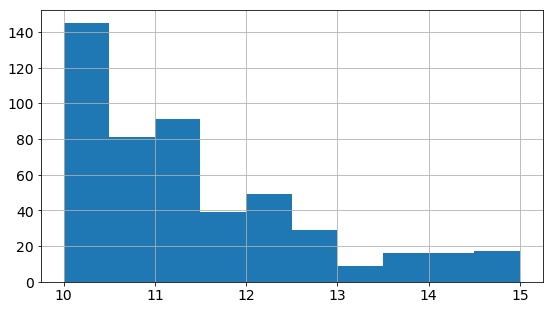

In [12]:
# Filter outliers in hspf
print(dfd.hspf.describe())
dfd.hspf.hist()

In [13]:
# Must have an HSPF of at least 10 to make list.  For now use 18 as an
# upper limit, but later that may not be high enough.
orig_ct = len(dfd)
dfd = dfd.query('hspf >= 10.0 and hspf <= 18')
print(len(dfd) - orig_ct, 'eliminated')

0 eliminated


count    492.000000
mean       2.453949
std        1.437957
min        0.750000
25%        1.397750
50%        1.970000
75%        3.011143
max        8.353000
Name: in_pwr_5F_max, dtype: float64


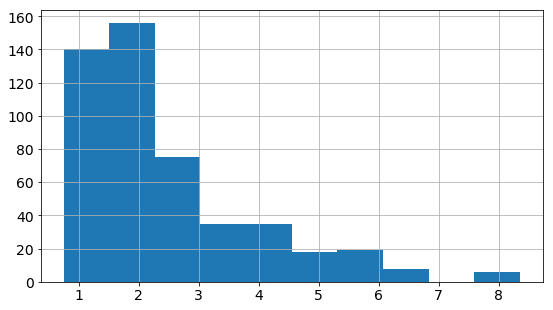

In [14]:
# Filter outliers in Input Power
print(dfd.in_pwr_5F_max.describe())
dfd.in_pwr_5F_max.hist()

In [15]:
orig_ct = len(dfd)
dfd = dfd.query('in_pwr_5F_max >= 0.75 and in_pwr_5F_max <= 10.0')
print(len(dfd) - orig_ct, 'eliminated')

0 eliminated


count      492.000000
mean     17282.673211
std      10026.959518
min       5736.000000
25%      10488.000000
50%      13660.000000
75%      20925.000000
max      57000.000000
Name: capacity_5F_max, dtype: float64


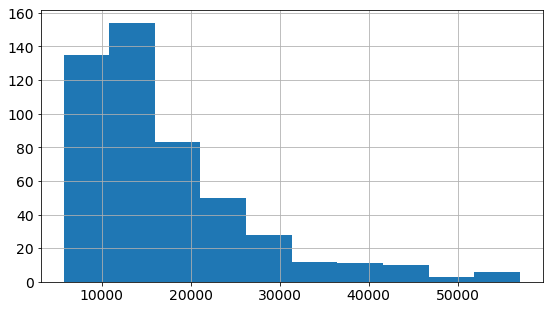

In [16]:
# Filter outliers in Max Capacity
print(dfd.capacity_5F_max.describe())
dfd.capacity_5F_max.hist()

In [17]:
orig_ct = len(dfd)
dfd = dfd.query('capacity_5F_max >= 5000. and capacity_5F_max <= 70000.')
print(len(dfd) - orig_ct, 'eliminated')

0 eliminated


In [23]:
# Find models to put on popular list
df_pop = dfd.query("hspf >= 11.5 and brand in ('Fujitsu', 'Mitsubishi', 'Mitsubishi Electric', 'Panasonic')")
df_pop

,brand,ahri_num,outdoor_model,indoor_model,hspf,in_pwr_5F_max,capacity_5F_max
548,Fujitsu,5063325,AOU9RLS2,ASU9RLS2,12.5,2.060,15000.0
549,Fujitsu,5063326,AOU12RLS2,ASU12RLS2,12.0,2.100,16500.0
550,Fujitsu,5751311,AOU9RLFC,AUU9RLF,13.0,1.870,15000.0
551,Fujitsu,5751312,AOU9RLFC,ARU9RLF,12.2,1.870,15000.0
552,Fujitsu,5751313,AOU12RLFC,AUU12RLF,12.2,2.250,16500.0
553,Fujitsu,5751314,AOU12RLFC,ARU12RLF,11.5,2.250,16500.0
554,Fujitsu,6936995,AOU9RLFF,AGU9RLF,12.6,2.100,14000.0
555,Fujitsu,6936996,AOU12RLFF,AGU12RLF,11.6,2.170,15000.0
557,Fujitsu,6937309,AOU9RLFFH,AGU9RLF,12.4,2.250,14000.0
563,Fujitsu,7993242,AOU12RLS3,ASU12RLS3,14.0,2.100,16500.0


In [28]:
dfd['popular'] = False
dfd.loc[df_pop.index, 'popular'] =  True
dfd.query('popular == True')

,brand,ahri_num,outdoor_model,indoor_model,hspf,in_pwr_5F_max,capacity_5F_max,popular
548,Fujitsu,5063325,AOU9RLS2,ASU9RLS2,12.5,2.060,15000.0,True
549,Fujitsu,5063326,AOU12RLS2,ASU12RLS2,12.0,2.100,16500.0,True
550,Fujitsu,5751311,AOU9RLFC,AUU9RLF,13.0,1.870,15000.0,True
551,Fujitsu,5751312,AOU9RLFC,ARU9RLF,12.2,1.870,15000.0,True
552,Fujitsu,5751313,AOU12RLFC,AUU12RLF,12.2,2.250,16500.0,True
553,Fujitsu,5751314,AOU12RLFC,ARU12RLF,11.5,2.250,16500.0,True
554,Fujitsu,6936995,AOU9RLFF,AGU9RLF,12.6,2.100,14000.0,True
555,Fujitsu,6936996,AOU12RLFF,AGU12RLF,11.6,2.170,15000.0,True
557,Fujitsu,6937309,AOU9RLFFH,AGU9RLF,12.4,2.250,14000.0,True
563,Fujitsu,7993242,AOU12RLS3,ASU12RLS3,14.0,2.100,16500.0,True


In [29]:
au.save_df(dfd, f'data/heat-pump/proc/hp_specs')

saving DataFrame to data/heat-pump/proc/hp_specs.pkl and .csv


In [30]:
# When convinced Raw and Processed data is good, upload to bucket.
# Upload raw heat pump spreadsheet to the bucket.
bucket.upload_dir('data/heat-pump/raw/', 'heat-pump/raw', clear_dest_dir=True)

deleting heat-pump/raw/ColdClimateAir-SourceHeatPumpSpecificationProductListing-Updated7.12.18_1.xlsx
uploaded data/heat-pump/raw/ColdClimateAir-SourceHeatPumpSpecificationProductListing-Updated7.12.18_1.xlsx with Content Type: application/vnd.openxmlformats-officedocument.spreadsheetml.sheet


In [31]:
bucket.upload_dir('data/heat-pump/proc/', 'heat-pump/proc', clear_dest_dir=True)

deleting heat-pump/proc/hp_specs.csv
deleting heat-pump/proc/hp_specs.pkl
uploaded data/heat-pump/proc/hp_specs.csv with Content Type: text/csv
uploaded data/heat-pump/proc/hp_specs.pkl with Content Type: application/octet-stream
